In [1]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
try:
    df = pd.read_csv('../datos/partidas_lol.csv')
    print("Datos cargados exitosamente.")
    print(f"Dimensiones del DataFrame: {df.shape}")
except FileNotFoundError:
    print("Error: El archivo 'partidas_lol.csv' no se encontró.")
    print("Asegúrate de que el archivo CSV generado por el script de extracción esté en la misma carpeta que este notebook.")
    # Si el archivo no se encuentra, puedes detener la ejecución o proporcionar un DataFrame de ejemplo para que el resto del código no falle.
    # Para este ejemplo, si no encuentra el archivo, el script se detendrá.
    raise

# Mostrar información básica del DataFrame
print("\nInformación del DataFrame:")
df.info()
df

Datos cargados exitosamente.
Dimensiones del DataFrame: (884, 20)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   matchId                           884 non-null    object
 1   gameDuration                      884 non-null    int64 
 2   diff_gold                         884 non-null    int64 
 3   diff_kills                        884 non-null    int64 
 4   blue_totalDamageDealtToChampions  884 non-null    int64 
 5   red_totalDamageDealtToChampions   884 non-null    int64 
 6   blue_wardsPlaced                  884 non-null    int64 
 7   red_wardsPlaced                   884 non-null    int64 
 8   blue_champ1_name                  884 non-null    object
 9   blue_champ2_name                  884 non-null    object
 10  blue_champ3_name                  884 non-null    ob

,matchId,gameDuration,diff_gold,diff_kills,blue_totalDamageDealtToChampions,red_totalDamageDealtToChampions,blue_wardsPlaced,red_wardsPlaced,blue_champ1_name,blue_champ2_name,blue_champ3_name,blue_champ4_name,blue_champ5_name,red_champ1_name,red_champ2_name,red_champ3_name,red_champ4_name,red_champ5_name,firstBlood,blue_win
0,LA1_1608550617,2359,-6949,1,142182,148927,108,89,Gwen,Gragas,Zoe,Jhin,Thresh,Gangplank,Viego,Aurora,Tristana,Braum,1,0
1,LA1_1613637947,1139,10767,25,70004,46281,44,24,Pantheon,Nunu & Willump,Vladimir,Miss Fortune,Rell,Shen,Hecarim,Hwei,Yasuo,Alistar,0,1
2,LA1_1620124107,2043,-6521,-10,147880,156986,83,65,Urgot,Viego,Lissandra,Yasuo,Blitzcrank,Malphite,Jarvan IV,Vladimir,Smolder,Maokai,0,0
3,LA1_1607040918,1891,6096,13,113599,86762,90,60,Jayce,Talon,Aurelion Sol,Caitlyn,Karma,Irelia,Poppy,Akali,Tristana,Nami,0,1
4,LA1_1612640786,1009,4992,9,42414,37942,38,27,Kled,Hecarim,Aurora,Tristana,Yuumi,Gragas,Ekko,Zed,Lucian,Thresh,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,LA1_1613796643,1528,-14449,-19,74918,105699,58,65,Malzahar,Rumble,Nasus,Lucian,Karma,Ryze,Xin Zhao,Corki,Draven,Seraphine,0,0
880,LA1_1619016692,1480,-9121,-10,66583,75044,55,48,Darius,Kha'Zix,Taliyah,Xayah,Thresh,Aatrox,Xin Zhao,Mordekaiser,Tristana,Lulu,1,0
881,LA1_1604282555,2103,4309,-1,168065,132952,79,77,Sion,Lillia,Vladimir,Kai'Sa,Seraphine,Darius,Viego,Cho'Gath,Jhin,Zilean,1,1
882,LA2_1503647110,2419,-1876,-4,187961,153168,89,102,Riven,Viego,Ahri,Ezreal,Sona,Tahm Kench,Nunu & Willump,Akali,Vayne,Rell,1,0


In [2]:
# Definir características numéricas y categóricas
numerical_features = [
    'gameDuration', 'diff_gold', 'diff_kills',
    'blue_totalDamageDealtToChampions', 'red_totalDamageDealtToChampions',
    'blue_wardsPlaced', 'red_wardsPlaced'
]

# Las IDs de los campeones son numéricas, pero representan categorías.
# 'firstBlood' también es 0/1 pero representa una categoría binaria.
categorical_features = [
    'blue_champ1_name', 'blue_champ2_name', 'blue_champ3_name', 'blue_champ4_name', 'blue_champ5_name',
    'red_champ1_name', 'red_champ2_name', 'red_champ3_name', 'red_champ4_name', 'red_champ5_name',
    'firstBlood'
]

# Definir la variable objetivo
target = 'blue_win'

# Separar características (X) y variable objetivo (y)
X = df[numerical_features + categorical_features]
y = df[target]

print(f"\nCaracterísticas (X) seleccionadas: {X.columns.tolist()}")
print(f"Variable objetivo (y): {target}")

# Crear un preprocesador usando ColumnTransformer
# Esto aplicará OneHotEncoder solo a las columnas categóricas
# y dejará las numéricas intactas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Pasa las numéricas sin cambios
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Aplica One-Hot Encoding a las categóricas
    ])

print("\nPreprocesador configurado para One-Hot Encoding de características categóricas.")


Características (X) seleccionadas: ['gameDuration', 'diff_gold', 'diff_kills', 'blue_totalDamageDealtToChampions', 'red_totalDamageDealtToChampions', 'blue_wardsPlaced', 'red_wardsPlaced', 'blue_champ1_name', 'blue_champ2_name', 'blue_champ3_name', 'blue_champ4_name', 'blue_champ5_name', 'red_champ1_name', 'red_champ2_name', 'red_champ3_name', 'red_champ4_name', 'red_champ5_name', 'firstBlood']
Variable objetivo (y): blue_win

Preprocesador configurado para One-Hot Encoding de características categóricas.


In [3]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# test_size=0.2 significa que el 20% de los datos se usarán para prueba
# random_state asegura que la división sea la misma cada vez que ejecutes el código
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nDimensiones del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test): {X_test.shape}")
print(f"Dimensiones del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (y_test): {y_test.shape}")


Dimensiones del conjunto de entrenamiento (X_train): (618, 18)
Dimensiones del conjunto de prueba (X_test): (266, 18)
Dimensiones del conjunto de entrenamiento (y_train): (618,)
Dimensiones del conjunto de prueba (y_test): (266,)


In [4]:
# Crear un pipeline que primero preprocese los datos y luego aplique el modelo
# Modelo 1: Random Forest Classifier
print("\nEntrenando modelo: Random Forest Classifier...")
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]) # n_jobs=-1 usa todos los cores disponibles

# Entrenar el modelo
model_rf.fit(X_train, y_train)
print("Modelo Random Forest entrenado exitosamente.")

# --- Opcional: Probar otros modelos ---
# Modelo 2: Regresión Logística (más simple, buena línea base)
# print("\nEntrenando modelo: Logistic Regression...")
# model_lr = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))])
# model_lr.fit(X_train, y_train)
# print("Modelo Logistic Regression entrenado exitosamente.")

# Modelo 3: Gradient Boosting Classifier (a menudo muy potente)
# print("\nEntrenando modelo: Gradient Boosting Classifier...")
# model_gb = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))])
# model_gb.fit(X_train, y_train)
# print("Modelo Gradient Boosting Classifier entrenado exitosamente.")


Entrenando modelo: Random Forest Classifier...
Modelo Random Forest entrenado exitosamente.



--- Evaluación del Modelo Random Forest ---
Precisión (Accuracy): 0.9887

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       126
           1       0.99      0.99      0.99       140

    accuracy                           0.99       266
   macro avg       0.99      0.99      0.99       266
weighted avg       0.99      0.99      0.99       266



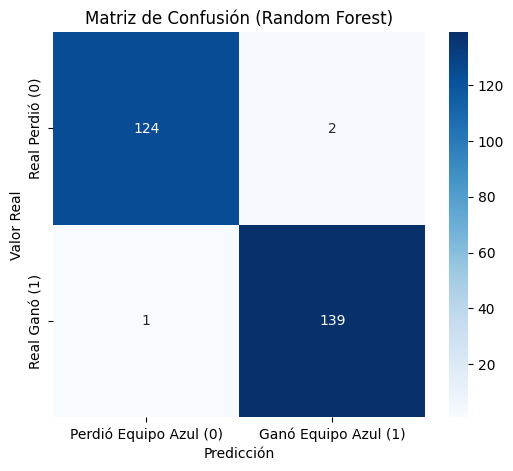

In [5]:
# Realizar predicciones en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

print("\n--- Evaluación del Modelo Random Forest ---")
print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Perdió Equipo Azul (0)', 'Ganó Equipo Azul (1)'],
            yticklabels=['Real Perdió (0)', 'Real Ganó (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Random Forest)')
plt.show()

# --- Opcional: Evaluar otros modelos si los entrenaste ---
# if 'model_lr' in locals():
#     y_pred_lr = model_lr.predict(X_test)
#     print("\n--- Evaluación del Modelo Logistic Regression ---")
#     print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_lr):.4f}")
#     print("\nReporte de Clasificación:")
#     print(classification_report(y_test, y_pred_lr))

# if 'model_gb' in locals():
#     y_pred_gb = model_gb.predict(X_test)
#     print("\n--- Evaluación del Modelo Gradient Boosting Classifier ---")
#     print(f"Precisión (Accuracy): {accuracy_score(y_test, y_pred_gb):.4f}")
#     print("\nReporte de Clasificación:")
#     print(classification_report(y_test, y_pred_gb))